<a href="https://www.kaggle.com/code/emanafi/lyricgen?scriptVersionId=250457367" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**LyricGen - An AI-Powered Lyric Completion Tool**

By Eman Sarah Afi

_Fall 2024_

# **1. Data Cleaning & Preprocessing:**

In [1]:
# Import necessary libraries
import os
import pandas as pd
import random
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout, MultiHeadAttention, Layer
from tensorflow.keras.models import Model

# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Load the dataset
dataset = pd.read_csv('/kaggle/input/genius-song-lyrics-with-language-information/song_lyrics.csv')

# Display the first 10 rows of the dataset
print(dataset.head(10))

# Display dataset info (columns, data-types, non-null counts)
print(dataset.info())

               title  tag     artist  year   views  \
0          Killa Cam  rap    Cam'ron  2004  173166   
1         Can I Live  rap      JAY-Z  1996  468624   
2  Forgive Me Father  rap   Fabolous  2003    4743   
3       Down and Out  rap    Cam'ron  2004  144404   
4             Fly In  rap  Lil Wayne  2005   78271   
5     Lollipop Remix  rap  Lil Wayne  2008  580832   
6         Im Not You  rap     Clipse  2002   28645   
7        Family Ties  rap    Cam'ron  2004   41960   
8  Rockin and Rollin  rap    Cam'ron  1998    6399   
9      Lord You Know  rap    Cam'ron  2004   11882   

                                       features  \
0                   {"Cam\\'ron","Opera Steve"}   
1                                            {}   
2                                            {}   
3  {"Cam\\'ron","Kanye West","Syleena Johnson"}   
4                                            {}   
5                 {"Kanye West","Static Major"}   
6   {Jadakiss,"Styles P","Roscoe P. Coldchain"} 

In [3]:
# Print the percentage of missing values per column
print(dataset.isnull().sum() / len(dataset) * 100)

title            0.003661
tag              0.000000
artist           0.000000
year             0.000000
views            0.000000
features         0.000000
lyrics           0.000000
id               0.000000
language_cld3    1.771539
language_ft      2.615886
language         4.419170
dtype: float64


In [4]:
# Define target languages (English, French, Arabic)
target_languages = ['en', 'fr', 'ar']

# Total rows in the dataset
total_rows = len(dataset)

# Calculate the percentage for each target language
percentages = {
    lang: (len(dataset[dataset['language'] == lang]) / total_rows) * 100
    for lang in target_languages
}

# Display the percentages
for lang, percentage in percentages.items():
    print(f"Percentage of rows with '{lang}': {percentage:.2f}%")

Percentage of rows with 'en': 65.71%
Percentage of rows with 'fr': 3.69%
Percentage of rows with 'ar': 0.19%


Naturally, considering that the intention is to work with three languages (English, French & Arabic), we have to filter the dataset to include the rows with these languages only. 

However, considering that the percentage of 'en' is extremely high, which could lead to performance issues on Kaggle, it is recommended to take a sample of rows that have 'en' as the language.

Other than that, the text is cleaned by removing punctuation, unique characters, and converting it to lowercase (except for Arabic). Plus, structural tags (e.g., [Chorus: ...]) will be removed to reduce the noise, and repeated lyrics were handled to prevent redundancy in tokenized sequences.

Finally, the dataset should only keep the columns it needs for this project, which in this case, the kept columns are 'language' and 'cleaned_lyrics'.

In [5]:
# Filter dataset using the 'language' column and create an explicit copy
filtered_dataset = dataset[dataset['language'].isin(target_languages)].copy()

# Function for cleaning multilingual lyrics (removes punctuation)
def clean_multilingual_lyrics_simple(lyric, lang):
    if pd.isnull(lyric):  # Handle missing lyrics
        return ""
    
    # Remove structural tags (e.g., [Chorus: Opera Steve & Cam'ron])
    lyric = re.sub(r"\[.*?\]", "", lyric)
    
    # Handle language-specific cleaning
    if lang == 'en':
        lyric = re.sub(r"[^a-zA-Z0-9\s]", "", lyric).lower()
    elif lang == 'fr':
        lyric = re.sub(r"[^a-zA-ZÀ-ÿ0-9\s]", "", lyric).lower()
    elif lang == 'ar':
        lyric = re.sub(r"[^\u0600-\u06FF0-9\s]", "", lyric)
    
    # Remove extra whitespace
    lyric = " ".join(lyric.split())
    return lyric

# Inspect group sizes
group_sizes = filtered_dataset['language'].value_counts()
print("Group sizes before sampling:", group_sizes)

# Set target sample size for each language
target_sample_size = 9000

# Sample data for each language
sampled_en = filtered_dataset[filtered_dataset['language'] == 'en'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'en'])),
    random_state=42
)

sampled_fr = filtered_dataset[filtered_dataset['language'] == 'fr'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'fr'])),
    random_state=42
)

sampled_ar = filtered_dataset[filtered_dataset['language'] == 'ar'].sample(
    n=min(target_sample_size, len(filtered_dataset[filtered_dataset['language'] == 'ar'])),
    random_state=42
)

# Combine all sampled data
sampled_dataset = pd.concat([sampled_en, sampled_fr, sampled_ar])

# Apply the cleaning function to the sampled dataset
sampled_dataset = sampled_dataset.assign(
    cleaned_lyrics=sampled_dataset.apply(
        lambda row: clean_multilingual_lyrics_simple(row['lyrics'], row['language']),
        axis=1
    )
)

# Keep only 'language' and 'cleaned_lyrics' columns
sampled_dataset = sampled_dataset[['language', 'cleaned_lyrics']]

# Display dataset summary
print(f"Final dataset columns: {sampled_dataset.columns.tolist()}")
print(f"Number of rows: {len(sampled_dataset)}")
print(sampled_dataset['language'].value_counts())
print(sampled_dataset.head())

Group sizes before sampling: language
en    3374198
fr     189436
ar       9889
Name: count, dtype: int64
Final dataset columns: ['language', 'cleaned_lyrics']
Number of rows: 27000
language
en    9000
fr    9000
ar    9000
Name: count, dtype: int64
        language                                     cleaned_lyrics
2645152       en  dont want to be along anymore dont want to hea...
1939177       en  africa rappers fuck you i dey greet so you guy...
969631        en  every time i kiss somebody new i make believe ...
4041818       en  i am the one who calls your name the day you l...
1976310       en  hella sketchy im always glistenin im always gl...


After the cleaning phase, it is preferred to check if there are any duplicated rows before proceeding with the embedding & tokenization phase. 

In [6]:
# Number of duplicated rows
num_duplicates = sampled_dataset.duplicated().sum()

# Percentage of duplicated rows
percentage_duplicates = (num_duplicates / len(sampled_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

final_dataset = sampled_dataset.drop_duplicates()

# Number of duplicated rows
num_duplicates = final_dataset.duplicated().sum()

# Check for duplicated rows again
percentage_duplicates = (num_duplicates / len(final_dataset)) * 100
print(f"Percentage of duplicated rows: {percentage_duplicates:.2f}%")

Percentage of duplicated rows: 0.27%
Percentage of duplicated rows: 0.00%


In [7]:
# Print the percentage of missing values per column
print(final_dataset.isnull().sum() / len(final_dataset) * 100)

language          0.0
cleaned_lyrics    0.0
dtype: float64


# **2. Embedding Preparation:**

The purpose of the embedding phase here is to transform text data into numerical representations suitable for Transformer-based models. 

To explain further:
- max_vocab_size will the vocabulary to the most frequent 20,000 words.
- max_sequence_length will set a fixed sequence length of 20 for uniform input size.

These values were chosen while taking into consideration the complexity of the multilingual and diverse nature of the Genius dataset

Then, tokenization is done for all languages where the cleaned lyrics are into sequences of integers, and out-of-vocabulary words are replaced by a special token (<OOV>). After that, padding will ensure that the sequences have the same length for compatibility reasons.

In [8]:
# Define parameters
max_vocab_size = 20000
max_sequence_length = 80
sos_token = "<sos>"
eos_token = "<eos>"

# 1. Create a single, unified tokenizer for all languages
# This is more efficient and allows the model to find cross-lingual relationships.
tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")

# 2. Prepare all texts with special tokens
all_lyrics = final_dataset['cleaned_lyrics'].astype(str).tolist()
texts_with_tokens = [f"{sos_token} {text} {eos_token}" for text in all_lyrics]

# 3. Fit the single tokenizer on all available text data
print("Fitting a unified tokenizer on all languages...")
tokenizer.fit_on_texts(texts_with_tokens)
print("Tokenizer fitting complete.")

# 4. Use the actual discovered vocabulary size (this is more accurate)
vocab_size = len(tokenizer.word_index) + 1
print(f"Discovered vocabulary size: {vocab_size}")

# 5. Convert all texts to integer sequences
print("Converting texts to sequences...")
sequences = tokenizer.texts_to_sequences(texts_with_tokens)

# 6. Pad all sequences to the same fixed length
# This single array will be our main dataset.
X_padded = pad_sequences(
    sequences, 
    maxlen=max_sequence_length, 
    padding='post', 
    truncating='post',
    dtype='int32' # Ensure dtype is correct
)
print("Padding complete.")


# 7. Split the single dataset into training, validation, and test sets
X_train, X_temp = train_test_split(X_padded, test_size=0.2, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)


# --- Final Summaries ---
print(f"\nTotal padded sequences: {len(X_padded)}")
print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Example data
print(f"\nExample processed sequence (from X_train): \n{X_train[0]}")
print("\nData is now correctly prepared for the decoder-only transformer.")

Fitting a unified tokenizer on all languages...
Tokenizer fitting complete.
Discovered vocabulary size: 510228
Converting texts to sequences...
Padding complete.

Total padded sequences: 26928
Training samples: 21542
Validation samples: 2693
Test samples: 2693

Example processed sequence (from X_train): 
[   35    66    50    51    19     1  8733    66    50    51    19     1
  8733    59  6309    10   113   848    66    50    51    19     1  8733
    66    50    51    19     1  8733    59  6309    10   113   848     5
    90   365    10   945   163     2  3989   942  2442    23     7  3989
    27  1075   386  2346  9779  4831    52  1952     7  1113    52    51
  2831   168     1   569   209   299  1500     1  4992   198     3   144
   412    90   237 18120   704    57   190    10]

Data is now correctly prepared for the decoder-only transformer.


# **3. Output Readiness Check:**

This code segment will simply check if:
- The output shape is a 2D array for Transformer input.
- The sequences are of type int32 to ensure compatibility with embedding layers.
- Labels are included and match the number of sequences.

In [9]:
# Check the shape of the full padded dataset
print(f"Shape of the full dataset (X_padded): {X_padded.shape}")
assert len(X_padded.shape) == 2, "Padded data should be 2D (num_samples, max_sequence_length)."

# Check the shape of the training set as a representative sample
print(f"Shape of the training set (X_train): {X_train.shape}")
assert len(X_train.shape) == 2, "Training data should be 2D (num_samples, max_sequence_length)."

# Check the data type of the sequences
print(f"Data type of padded sequences (X_padded): {X_padded.dtype}")
assert X_padded.dtype == 'int32', "Padded sequences should be of type int32 for embedding layers."

# Validate the vocabulary size against the maximum token ID in the dataset
# This is a crucial check to prevent errors in the Embedding layer.
max_token_id = np.max(X_padded)
print(f"\nMaximum token ID found in the dataset: {max_token_id}")
print(f"Tokenizer vocabulary size (len(word_index) + 1): {vocab_size}")
assert max_token_id < vocab_size, f"A token ID ({max_token_id}) exceeds the vocabulary size ({vocab_size})."
print("Token IDs are all within the vocabulary range.")

# Demonstrate how a single sequence is split into an input/target pair for the model
example_input_for_model = X_train[0, :-1]
example_target_for_model = X_train[0, 1:]

print("\n--- Example of how data is fed to the model ---")
print("Original sequence (from X_train[0]):", X_train[0])
print("Model Input (sequence[:-1]):        ", example_input_for_model)
print("Model Target (sequence[1:]):         ", example_target_for_model)

print("\n\nProcessed data is ready for the Transformer model.")

Shape of the full dataset (X_padded): (26928, 80)
Shape of the training set (X_train): (21542, 80)
Data type of padded sequences (X_padded): int32

Maximum token ID found in the dataset: 19999
Tokenizer vocabulary size (len(word_index) + 1): 510228
Token IDs are all within the vocabulary range.

--- Example of how data is fed to the model ---
Original sequence (from X_train[0]): [   35    66    50    51    19     1  8733    66    50    51    19     1
  8733    59  6309    10   113   848    66    50    51    19     1  8733
    66    50    51    19     1  8733    59  6309    10   113   848     5
    90   365    10   945   163     2  3989   942  2442    23     7  3989
    27  1075   386  2346  9779  4831    52  1952     7  1113    52    51
  2831   168     1   569   209   299  1500     1  4992   198     3   144
   412    90   237 18120   704    57   190    10]
Model Input (sequence[:-1]):         [   35    66    50    51    19     1  8733    66    50    51    19     1
  8733    59  6309  

# **4. Transformer Architecture:**

This code defines a custom and highly flexible TensorFlow layer called `PositionalEncoding`. Its purpose is to inject information about the position of each token into the sequence embeddings, which is crucial for Transformer models that do not otherwise have an inherent sense of order.

This updated version is designed to be robust for generative tasks by creating the encoding **dynamically** for any given sequence length.

#### 1. `__init__` method:

Initializes the layer. It is very lightweight and only requires the `embed_dim` (the embedding dimension of the model) to be stored for use during the forward pass. Unlike previous static versions, it does **not** pre-compute a fixed-size encoding matrix.

#### 2. `call` method:

This method defines the forward pass of the layer and is where the positional encoding is generated "on-the-fly" for each input batch.

*   **1. Dynamic Shape Detection:** It first determines the `sequence_length` directly from the input tensor it receives. This is the key to its flexibility, as it works for any length.
*   **2. Angle Calculation:** It calculates the positional encoding angles using the standard Transformer formula. It creates a tensor of positions (from 0 to `sequence_length - 1`) and combines it with a term based on the embedding dimension.
*   **3. Sine and Cosine Application:** It applies the `sin` function to even indices of the embedding dimension and the `cos` function to the odd indices, creating the final encoding signals.
*   **4. Addition to Input:** Finally, it adds this newly generated positional encoding matrix directly to the original input token embeddings.

The key advantage of this dynamic approach is its ability to handle sequences of varying lengths. This is essential during auto-regressive generation (where the input sequence grows by one token at each step), ensuring the model can be trained on fixed-length sequences but used for generation on variable-length ones without encountering shape-mismatch errors.

In [10]:
class PositionalEncoding(Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Store embed_dim as an integer.
        self.embed_dim = embed_dim

    def call(self, inputs):
        """
        This version computes the positional encoding dynamically based on the
        input sequence length, making it flexible for generation.
        """
        seq_len = tf.shape(inputs)[1]
        
        position = tf.range(start=0, limit=seq_len, delta=1, dtype=tf.float32)
        
        # The division here will work fine even with an integer embed_dim
        div_term = tf.pow(10000.0, (2.0 * tf.range(0, self.embed_dim, 2, dtype=tf.float32)) / float(self.embed_dim))
        
        position = position[:, tf.newaxis]
        div_term = div_term[tf.newaxis, :]
        
        angle_rads = position / div_term
        
        sin_part = tf.sin(angle_rads)
        cos_part = tf.cos(angle_rads)
        
        # Interleave sin and cos parts
        # This reshape now receives an integer for self.embed_dim and will work correctly.
        encoding = tf.reshape(tf.stack([sin_part, cos_part], axis=-1), [seq_len, self.embed_dim])
        
        encoding = encoding[tf.newaxis, :, :]
        
        return inputs + encoding

This code defines a `TransformerDecoderBlock` as a custom Keras `Layer`. This block is the fundamental building block of a **Decoder-Only (GPT-style) Transformer**. Unlike a standard Transformer decoder, it does not have a second attention layer for cross-attention with an encoder, as there is no encoder in this architecture.

Its main purpose is to take a sequence of token embeddings and enrich them with contextual information from preceding tokens in the sequence.

Here's a breakdown of its components:

#### Sub-layer 1: Masked Multi-Head Self-Attention

*   **Purpose:** This is the core of the block. It allows each token in the sequence to look at and gather information from all the *previous* tokens in the same sequence.
*   **Causal Mask:** A crucial "causal mask" is applied during this step. This mask prevents any token from "cheating" by attending to future tokens. For example, when predicting the 5th word, the model can only see words 1 through 4. This is essential for a generative model that predicts one word at a time.
*   **Process:** The output of the attention mechanism is passed through a `Dropout` layer for regularization, and then combined with the original input via a residual connection (`Add`) and normalized with `LayerNormalization`.

#### Sub-layer 2: Position-wise Feed-Forward Network (FFN)

*   **Purpose:** This is a standard two-layer fully connected neural network that is applied independently to each position in the sequence. It provides additional learning capacity and transforms the representations learned by the attention layer.
*   **Structure:** It consists of two `Dense` layers, with a ReLU activation function in between.
*   **Process:** Similar to the first sub-layer, the FFN's output is regularized with `Dropout`, combined with the input from the previous step (the output of the first sub-layer) via a residual connection, and finally normalized.

---

#### **Input and Output:**

*   **Input:** The block takes a single tensor `inputs` with a shape of `(batch_size, sequence_length, embed_dim)`.
*   **Output:** It returns a tensor of the **exact same shape** `(batch_size, sequence_length, embed_dim)`, which can then be passed to the next `TransformerDecoderBlock` in the stack.

In [11]:
class TransformerDecoderBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(dropout_rate)
        self.dropout2 = Dropout(dropout_rate)

    def create_causal_mask(self, size):
        # Creates a boolean mask to prevent attention to future tokens.
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask[tf.newaxis, tf.newaxis, :, :] # (1, 1, size, size)

    def call(self, inputs):
        # The logic is now inside the `call` method
        input_shape = tf.shape(inputs)
        seq_len = input_shape[1]
        
        # 1. Create the causal mask dynamically
        causal_mask = self.create_causal_mask(seq_len)

        # 2. Masked Multi-Head Self-Attention
        # The mask is passed directly to the attention layer's call
        attention_output = self.mha(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        attention_output = self.dropout1(attention_output)
        out1 = self.layernorm1(inputs + attention_output)

        # 3. Feed-Forward Network
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        out2 = self.layernorm2(out1 + ffn_output)
        
        return out2

In [12]:
# The main function to build the complete Decoder-Only Transformer
def build_decoder_only_transformer(vocab_size, embed_dim, num_heads, ff_dim, num_decoder_layers, dropout_rate):
    inputs = Input(shape=(None,), dtype="int32", name="Input_Layer")
    
    # Embedding and Positional Encoding
    x = Embedding(vocab_size, embed_dim, name="Embedding_Layer")(inputs)
    # The layer no longer takes max_len
    x = PositionalEncoding(embed_dim)(x) 
    
    # Stack of Decoder Blocks
    for _ in range(num_decoder_layers):
        x = TransformerDecoderBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x)

    # Final Output Layer
    outputs = Dense(vocab_size, activation="softmax", name="Output_Layer")(x)
    
    return Model(inputs=inputs, outputs=outputs, name="Decoder_Only_Transformer")

# **5. Training & Validation:**

This code segment orchestrates the training and evaluation of the **Decoder-Only (GPT-style) Transformer**. The model's objective is to function as a generative language model, learning to predict the next word in a sequence given the preceding words.

Here’s a breakdown of each key step:

#### **Hyperparameter Configuration**

These parameters define the model's architecture and the training process. They have been optimized to balance performance with the memory constraints of the GPU environment.

*   **`embed_dim` (256):** The size of the dense vector representation for each word/token.
*   **`num_heads` (4):** The number of attention heads in the multi-head attention mechanism. Reduced to save memory.
*   **`ff_dim` (1024):** The dimensionality of the inner layer of the feed-forward networks.
*   **`num_decoder_layers` (4):** The number of `TransformerDecoderBlock` layers stacked on top of each other. A shallower model is used to conserve memory.
*   **`dropout_rate` (0.1):** The fraction of units to drop during training to prevent overfitting.
*   **`vocab_size`:** The total number of unique tokens in the vocabulary. This is determined dynamically from the tokenizer in the previous data preparation step.
*   **`max_len`:** The maximum sequence length for padding.
*   **`batch_size` (16):** The number of sequences processed in each training step. This is kept small to manage memory usage.
*   **`epochs` (50):** The *maximum* number of times the model will iterate over the entire training dataset.
*   **`learning_rate` (1e-4):** The step size for the optimizer.

#### **Model Building and Compilation**

1.  **Build Transformer:** The `build_decoder_only_transformer` function is called to construct the Keras model using the hyperparameters defined above.
2.  **Compile Model:** The model is prepared for training. It uses:
    *   **Optimizer:** `AdamW`, a modern and robust variant of the Adam optimizer.
    *   **Loss Function:** `sparse_categorical_crossentropy`, which is standard for multi-class classification where the labels are integers (i.e., predicting the next token ID).
    *   **Metrics:** `accuracy` is tracked to monitor performance.
3.  **Summary:** A summary of the model's architecture, including layer names and parameter counts, is printed.

#### **Data Preparation for Generative Training**

The core task is next-word prediction. This is achieved by shifting the sequences:
*   **Model Input (`X_train_in`):** A sequence, excluding its last token (e.g., `<sos> i love to write`).
*   **Model Target (`y_train_out`):** The same sequence, excluding its first token (e.g., `i love to write <eos>`).

The model learns to produce the target when given the corresponding input. This is done for the training, validation, and test sets.

#### **Dataset Pipelines**
The prepared data arrays are converted into efficient `tf.data.Dataset` pipelines, which handle batching and prefetching for optimal GPU utilization.

#### **Callbacks for Intelligent Training**

*   **`ModelCheckpoint`:** Monitors the validation loss (`val_loss`) at the end of each epoch and saves the entire model (`.keras` format) only if its performance has improved. This ensures we always keep the best version of the model.
*   **`EarlyStopping`:** Also monitors the `val_loss`. If the validation loss does not improve for a set number of epochs (`patience=5`), it will stop the training process automatically to prevent wasting time and overfitting.

#### **Model Training and Evaluation**

1.  **Training:** The `model.fit()` method starts the training process using the prepared datasets and callbacks.
2.  **Load Best Model:** After training completes (or is stopped early), the best-performing model saved by `ModelCheckpoint` is loaded back.
3.  **Test Set Evaluation:** The final performance of this best model is measured on the unseen test set, providing an unbiased estimate of its generalization ability.

#### **Plotting Results**
Finally, the training and validation accuracy and loss are plotted over epochs to visually inspect the learning process, check for overfitting, and diagnose any training issues.

Building model with memory-optimized hyperparameters...


Model: "Decoder_Only_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)        │ (None, None)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Embedding_Layer (Embedding)     │ (None, None, 256)      │   130,618,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_encoding             │ (None, None, 256)      │             0 │
│ (PositionalEncoding)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_block       │ (None, None, 256)      │     1,578,496 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_block_1     │ (None, None, 256)      │     1,578,496 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_block_2     │ (None, None, 256)      │     1,578,496 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_decoder_block_3     │ (None, None, 256)      │     1,578,496 │
│ (TransformerDecoderBlock)       │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, None, 510228)   │   131,128,596 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 268,060,948 (1022.57 MB)

 Trainable params: 268,060,948 (1022.57 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 130618368 elements. This may consume a large amount of memory.
  warnings.warn(
I0000 00:00:1752504228.980543      67 service.cc:145] XLA service 0x7be94800fd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1752504228.982217      67 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1752504228.982223      67 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
W0000 00:00:1752504230.309113      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1752504239.359515      95 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 8 bytes spill stores, 

 241/2693 ━━━━━━━━━━━━━━━━━━━━ 9:36 235ms/step - accuracy: 0.1645 - loss: 11.5281

W0000 00:00:1752504318.153870      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1752504332.586994     123 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 8 bytes spill stores, 8 bytes spill loads

I0000 00:00:1752504333.953440     124 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_171', 1764 bytes spill stores, 1768 bytes spill loads

I0000 00:00:1752504334.137858     126 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_163', 100 bytes spill stores, 100 bytes spill loads

I0000 00:00:1752504348.119286      67 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_77', 8 bytes spill stores, 8 bytes spill loads



2693/2693 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.1802 - loss: 7.7053

W0000 00:00:1752505051.858219      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1752505087.057340      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1752505091.952003     162 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_30', 100 bytes spill stores, 100 bytes spill loads



2693/2693 ━━━━━━━━━━━━━━━━━━━━ 895s 316ms/step - accuracy: 0.1802 - loss: 7.7046 - val_accuracy: 0.4171 - val_loss: 3.8528
Epoch 2/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 850s 315ms/step - accuracy: 0.4723 - loss: 3.4050 - val_accuracy: 0.5953 - val_loss: 2.4593
Epoch 3/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 856s 318ms/step - accuracy: 0.5941 - loss: 2.3444 - val_accuracy: 0.6509 - val_loss: 1.9209
Epoch 4/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 859s 319ms/step - accuracy: 0.6400 - loss: 1.9093 - val_accuracy: 0.6945 - val_loss: 1.6148
Epoch 5/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 858s 319ms/step - accuracy: 0.6732 - loss: 1.6409 - val_accuracy: 0.7110 - val_loss: 1.4563
Epoch 6/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 857s 318ms/step - accuracy: 0.7024 - loss: 1.4501 - val_accuracy: 0.7602 - val_loss: 1.2296
Epoch 7/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 858s 318ms/step - accuracy: 0.7580 - loss: 1.1864 - val_accuracy: 0.8093 - val_loss: 0.9856
Epoch 8/50
2693/2693 ━━━━━━━━━━━━━━━━━━━━ 860s 319ms/step - accuracy: 0.7

/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_decoder_block', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer_decoder_block_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'transformer


Evaluating on test set...


W0000 00:00:1752536977.370891      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


336/337 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9862 - loss: 0.1057

W0000 00:00:1752537016.729139      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


337/337 ━━━━━━━━━━━━━━━━━━━━ 42s 117ms/step - accuracy: 0.9862 - loss: 0.1057
Test Loss: 0.1101
Test Accuracy: 0.9858


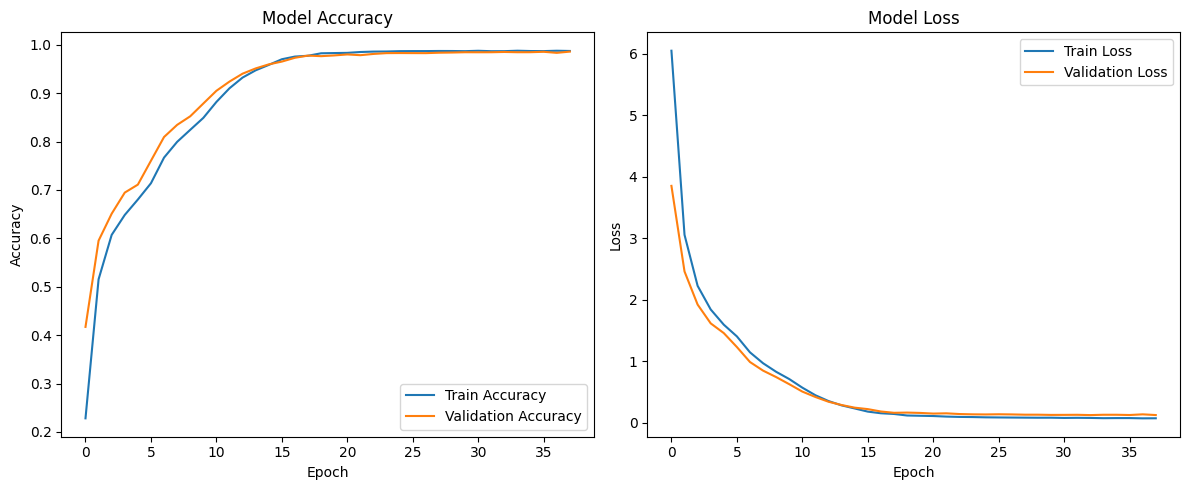

In [13]:
# 1. Reduce Batch Size (Most Important)
# A smaller batch size significantly reduces the memory needed for activations per step.
batch_size = 8  # Drastically reduced from 64. Start here. If it still fails, try 8.

# 2. Simplify the Model Architecture
# A shallower and narrower model has fewer weights and smaller intermediate tensors.
num_decoder_layers = 4 # Reduced from 6
num_heads = 4          # Reduced from 8

# 3. Other hyperparameters remain, but note the dependency on the previous cell
embed_dim = 256
ff_dim = 1024
dropout_rate = 0.1
max_len = max_sequence_length # This comes from the data prep cell
epochs = 50
learning_rate = 1e-4
# 'vocab_size' is automatically set in the data prep cell. Make sure that cell
# has a lower 'max_vocab_size' (e.g., 20000) for this to be effective.

# Build the new Decoder-Only model with the adjusted, lighter parameters
print("Building model with memory-optimized hyperparameters...")
transformer = build_decoder_only_transformer(
    vocab_size, # REMOVED max_len
    embed_dim, 
    num_heads, 
    ff_dim, 
    num_decoder_layers, 
    dropout_rate
)

# Compile the model using a modern, efficient optimizer
transformer.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=learning_rate), # AdamW is a good default
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
transformer.summary()

# --- Prepare the data for a generative model ---
# This logic is correct and does not need to change
X_train_in = X_train[:, :-1]
y_train_out = X_train[:, 1:]

X_val_in = X_val[:, :-1]
y_val_out = X_val[:, 1:]

X_test_in = X_test[:, :-1]
y_test_out = X_test[:, 1:]

# --- Create Dataset Pipelines ---
# The pipelines will now use the smaller batch_size
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_in, y_train_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE).shuffle(10000)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val_in, y_val_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test_in, y_test_out)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Add Callbacks for better training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "best_model.keras",
        save_best_only=True,
        monitor="val_loss"
    ),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)
]

# Train the Transformer
history = transformer.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

# Load the best model before evaluation
print("\nLoading best model from checkpoint...")
transformer = tf.keras.models.load_model("best_model.keras", custom_objects={
    "TransformerDecoderBlock": TransformerDecoderBlock,
    "PositionalEncoding": PositionalEncoding
})

# Evaluate the Model on the Test Set
print("\nEvaluating on test set...")
test_loss, test_accuracy = transformer.evaluate(test_dataset, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# **6. Lyrics Generation:**

This code segment demonstrates how to use the trained Decoder-Only Transformer to perform its primary function: **generative text completion**. It provides a framework for seeding the model with a prompt and having it auto-regressively generate a continuation.

#### **1. `get_seed_lyrics` Function**

*   **Purpose:** To extract a short, random phrase from the original dataset to use as a creative prompt for the model.
*   **Steps:**
    1.  Filters the `final_dataset` to get all lyrics for a specified `language`.
    2.  Randomly selects one full lyric from the filtered data.
    3.  Takes the first few words (`num_words`) of that lyric to form a concise seed prompt.
*   **Returns:** A string containing the seed prompt (e.g., "i see a red door").

#### **2. `generate_lyrics` Function**

*   **Purpose:** This is the core generation engine. It takes a trained model, a tokenizer, and a seed prompt, and produces a continuation of the text, one word at a time.
*   **Steps (Auto-regressive Decoding):**
    1.  The initial `seed_text` (which must include the `<sos>` token) is tokenized into a sequence of integer IDs.
    2.  The function enters a loop to generate the rest of the sequence up to `max_len`. In each step of the loop:
        *   The current sequence of generated tokens is fed into the `transformer_model`.
        *   The model outputs a probability distribution (logits) over the entire vocabulary for the *very next* token.
        *   **Top-K Sampling:** To avoid repetitive and boring text, it uses Top-K sampling. It identifies the `k` most likely next tokens and re-distributes the probability among just them. It then randomly samples a word from this smaller, high-quality pool. This adds a controlled amount of creativity.
        *   The chosen word's ID is appended to the `generated_sequence`.
    3.  The loop terminates if the model generates the `<eos>` (end-of-sequence) token or if the maximum length is reached.
*   **Returns:** The full generated text, decoded from token IDs back into a string.

#### **3. `compute_bleu` Function**

*   **Purpose:** This function provides a simple, quantitative measure of similarity between two texts.
*   **Note on Usage:** For a generative model, BLEU is not a definitive measure of "quality" because there is no single correct answer. However, it can be used for demonstration to compare the generated text against an original, though it's not a primary evaluation metric for this task.

#### **4. Main Generation Loop and Workflow**

The main part of the script iterates through a list of languages (`en`, `fr`, `ar`) to showcase the model's multilingual capabilities.

*   **For each language:**
    1.  A random `seed_prompt` is retrieved using the `get_seed_lyrics` function.
    2.  The required `<sos>` token is prepended to the prompt to prepare it for the model.
    3.  The `generate_lyrics` function is called to produce the full text continuation.
    4.  The output is cleaned up for display by removing the initial prompt, showing only the part the model generated itself.

*   **Outputs:** The script prints a clear, formatted output for each language, showing the **PROMPT** given to the model and the creative **MODEL GENERATION** that followed.

In [14]:
def get_seed_lyrics(dataset, language, num_words=10):
    """
    Get a random seed lyric from the dataset for a specific language.
    """
    lang_data = dataset[dataset['language'] == language]
    if lang_data.empty:
        return ""
    
    random_lyric = lang_data.sample(n=1)['cleaned_lyrics'].values[0]
    seed_words = random_lyric.split()[:num_words]
    return " ".join(seed_words)

def compute_bleu(reference, hypothesis, tokenizer):
    """
    Computes BLEU score. We won't use this for a generative model
    in this way, as there's no single "correct" reference.
    This is more for demonstration.
    """
    # A simple demonstration - not a robust evaluation for generative text
    reference_tokens = tokenizer.texts_to_sequences([reference])[0]
    hypothesis_tokens = tokenizer.texts_to_sequences([hypothesis])[0]
    
    if not hypothesis_tokens or not reference_tokens:
        return 0.0
        
    smooth_fn = SmoothingFunction().method1
    return sentence_bleu([reference_tokens], hypothesis_tokens, smoothing_function=smooth_fn)

def generate_lyrics(transformer_model, tokenizer, seed_text, max_len=50, k=20):
    """
    Generate lyrics using the Decoder-Only Transformer with Top-K sampling.
    """
    tokenized_seed = tokenizer.texts_to_sequences([seed_text])[0]
    generated_sequence = list(tokenized_seed)

    for _ in range(max_len - len(tokenized_seed)):
        current_input = tf.constant([generated_sequence])
        predictions = transformer_model.predict(current_input, verbose=0)
        last_token_logits = predictions[0, -1, :]
        
        top_k_logits, top_k_indices = tf.math.top_k(last_token_logits, k=k)
        top_k_probs = tf.nn.softmax(top_k_logits).numpy()
        
        next_word_id = np.random.choice(top_k_indices.numpy(), p=top_k_probs)
        
        if next_word_id == tokenizer.word_index.get("<eos>", 0):
            break
        
        generated_sequence.append(next_word_id)

    generated_text = tokenizer.sequences_to_texts([generated_sequence])[0]
    return generated_text

# --- Example Usage Loop ---
# We use the single tokenizer defined earlier
languages = ["en", "fr", "ar"]
for lang in languages:
    # Get a short seed text from the original dataset
    seed_prompt = get_seed_lyrics(final_dataset, lang, num_words=7)
    
    # The model expects the <sos> token to start
    seed_text_with_sos = f"{sos_token} {seed_prompt}"
    
    print(f"\n--- Generating lyrics in {lang.upper()} ---")
    print(f"PROMPT: {seed_prompt}\n")

    # Generate lyrics using the function
    generated_lyrics_full = generate_lyrics(
        transformer, 
        tokenizer, # Use the single, unified tokenizer
        seed_text_with_sos, 
        max_len=100,
        k=25
    )
    
    # Clean up the output for display
    # Remove the initial <sos> and the prompt itself
    generated_completion = generated_lyrics_full.replace(seed_text_with_sos, "").strip()
    
    print(f"MODEL GENERATION:\n{generated_completion}")


--- Generating lyrics in EN ---
PROMPT: we best be gettin on the road



I0000 00:00:1752537288.902166    1948 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 56 bytes spill stores, 56 bytes spill loads

I0000 00:00:1752537296.470729    1969 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1752537302.667307    1991 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1752537308.719977    2011 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 96 bytes spill stores, 96 bytes spill loads

I0000 00:00:1752537314.791149    2034 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 104 bytes spill stores, 104 bytes spill loads

I0000 00:00:1752537321.327768    2055 

MODEL GENERATION:
sos we best be gettin on the road je jfais أروح sos des la île vos que des sos et pour jte un tu mes pour des a en des me des est bout et et des que je pèse <OOV> pour la jfais en des des tu <OOV> <OOV> jfais <OOV> cest que la mais la un un toi tu toi sos cest te des des en que jfais toi me a on me et les des qui <OOV> me on me cest elle le en qui tes je ton en le ce des tas pour cest on des

--- Generating lyrics in FR ---
PROMPT: je mappelle francis jsuis dla piraterie corsaire

MODEL GENERATION:
sos je mappelle francis jsuis dla <OOV> <OOV> jfais des île aujourdhui la mes pèse jfais île de je veut sos veut التيار jfais graille veut en sos graille la lavoir entrer la شباك <OOV> ai tu <OOV> me est graille cest graille pour graille ah tu ah de sos des libérer vos jfais quil de jfais graille de et je de est pleuvoir libérer et est ah mais en <OOV> <OOV> de tout tu on en en <OOV> tu les mon <OOV> pour des en <OOV> et a est que tes des a cest les les a est des

--- Gener